# Code for Figure 4 a, b, d, and e

In [7]:
pip install biopython


   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
    --------------------------------------- 0.1/2.7 MB 1.7 MB/s eta 0:00:02
   ------- -------------------------------- 0.5/2.7 MB 5.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.7 MB 6.8 MB/s eta 0:00:01
   ---------------------- ----------------- 1.5/2.7 MB 8.7 MB/s eta 0:00:01
   ------------------------------ --------- 2.1/2.7 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------  2.7/2.7 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 9.1 MB/s eta 0:00:00


In [8]:
import pandas as pd
from Bio.Seq import reverse_complement
import matplotlib.pyplot as plt
from gzip import open as gzopen
from collections import Counter
from glob import glob
%matplotlib inline

In [9]:
def lib_analysis_func(fq_file, grna_design_file):
    #first I merged the fastq files using FLASH
    #now I go through the merged fastq file and extract gRNA target sequences

    left = "CGAAACACCG"
    right = "GTTTTAGAGCTA"
    no_left = []
    no_right = []
    nono = []
    target_seq = []
    print("reading fastq")
    with gzopen(fq_file, 'rt') as f:
        for i, line in enumerate(f):
            if i%3000000 == 0:
                print(i)
            if (i+3)%4 == 0:#why%4?
                read = line.strip()

                r_read = reverse_complement(read)
                if left in read and right in read:
                    target_seq.append(read[read.find(left)+len(left):read.find(right)])
                elif left in r_read and right in r_read:
                    target_seq.append(r_read[r_read.find(left)+len(left):r_read.find(right)])
                else:
                    found = False
                    if left not in read and left not in r_read:
                        no_left.append(read)
                        found = True
                    if right not in read and right not in r_read:
                        no_right.append(read)
                        found = True
                    if not found:
                        nono.append(read)
    print("done")
    total_reads=(i+1)/4 #why %4?
    print(f"no left fragment found: {len(no_left)/total_reads:.1%}")
    print(f"no right fragment found: {len(no_right)/total_reads:.1%}")
    print(f"no left nor right found: {len(nono)/total_reads:.3%}")
    print(f"percentage of reads with left and right: {len(target_seq)/total_reads:.1%}")
    tlens = pd.Series([len(x) for x in target_seq])
    print(f"percent of good reads with target gRNA that is 20bp long: {(tlens==20).sum()/len(tlens):.1%}")
    
    print("\nDesign file analysis")
    grna_design = pd.read_csv("20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")
    # extract the target gRNA sequence
    grna_design['target_seq'] = grna_design.Sequence.apply(lambda read: read[read.find(left)+len(left):read.find(right)])
    print("see if we have duplicates")
    print(grna_design['target_seq'].value_counts().value_counts())
    unique_genes = grna_design.Name.apply(lambda x: x.split("_")[0]).value_counts()

    ax = unique_genes.value_counts().sort_index().plot(kind='bar', figsize=(20,10), logy=True)
    ax.set_ylabel("Number of unique genes")
    ax.set_xlabel("Number of gRNAs per gene")
    plt.show()
    
    print(f"Number of unique genes (-1 non targeting control): {len(unique_genes)}")
    print(f"Number of genes with more than 5 gRNA: {sum(unique_genes>5)}")
    print(f"Number of genes with less than 5 gRNA: {sum(unique_genes<5)}")
    print(f"Percentage with 5 gRNA: {sum(unique_genes==5)/len(unique_genes):.1%}")
    
    print("\nmerging fastq reads with design file")
    target_seq_counter = Counter(target_seq)
    grna_design['target_count'] = grna_design.target_seq.apply(lambda x: target_seq_counter[x])
    print(f"coverage (at least 1 count): {sum(grna_design.target_count>1)/len(grna_design):.2%}")
    print(f"grna with 0 reads: {(grna_design.target_count==0).sum()}")
    a = grna_design.target_count
    print(f"skeq: {a.quantile(0.9)/a.quantile(0.1)}")# a.quantile ?
    return grna_design

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
done
no left fragment found: 8.2%
no right fragment found: 1.2%
no left nor right found: 0.000%
percentage of reads with left and right: 90.7%
percent of good reads with target gRNA that is 20bp long: 98.9%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


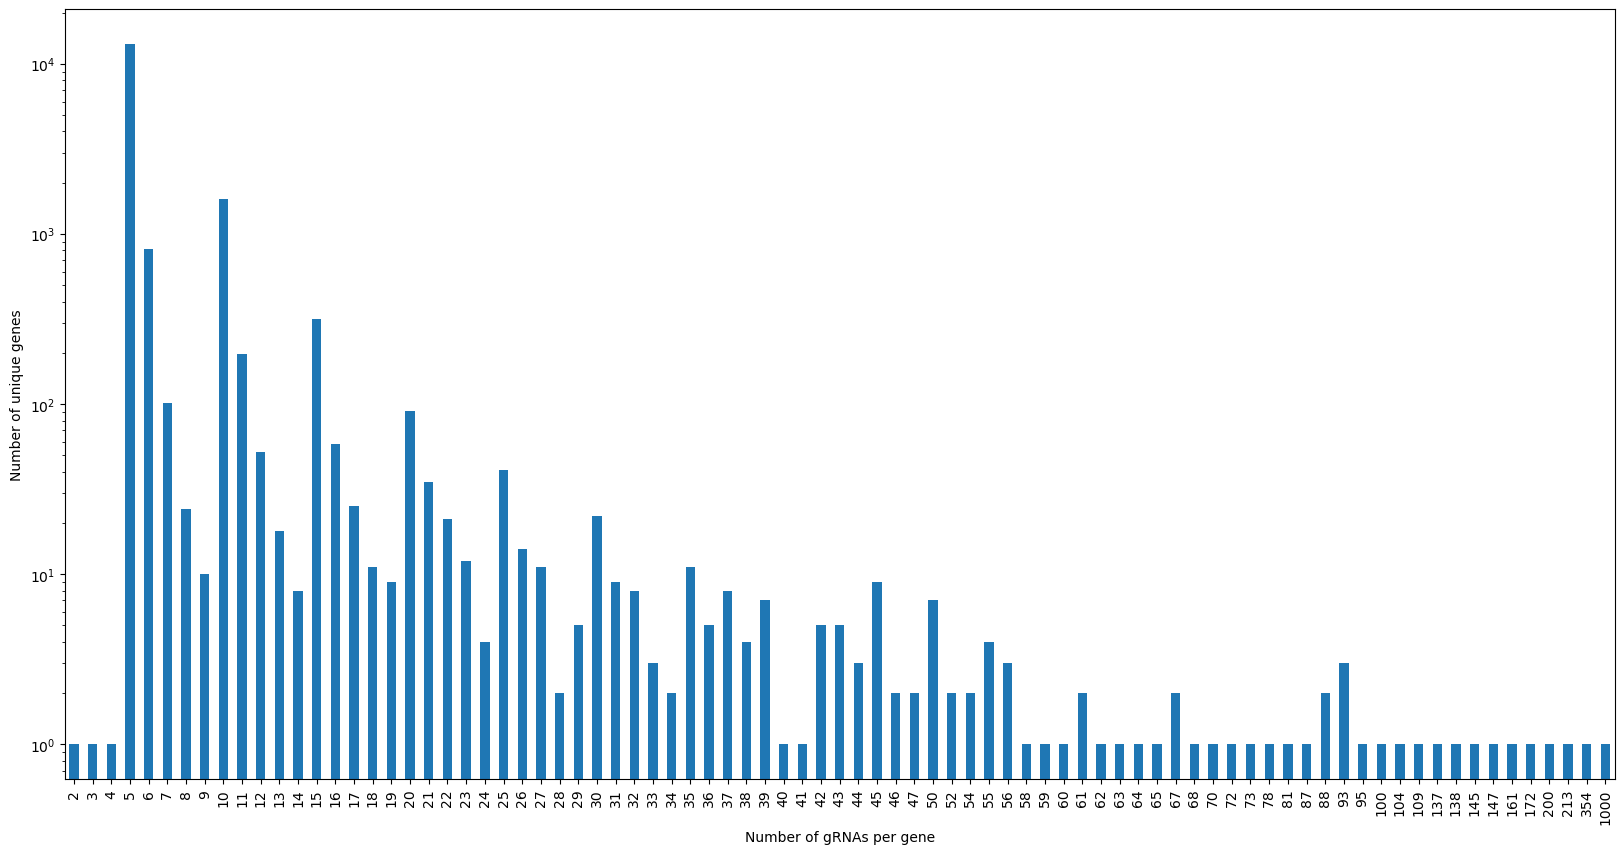

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 99.90%
grna with 0 reads: 93
skeq: 1.8888888888888888


In [10]:
a=lib_analysis_func("Liquidout.extendedFrags.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
done
no left fragment found: 7.3%
no right fragment found: 0.8%
no left nor right found: 0.000%
percentage of reads with left and right: 92.0%
percent of good reads with target gRNA that is 20bp long: 99.4%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


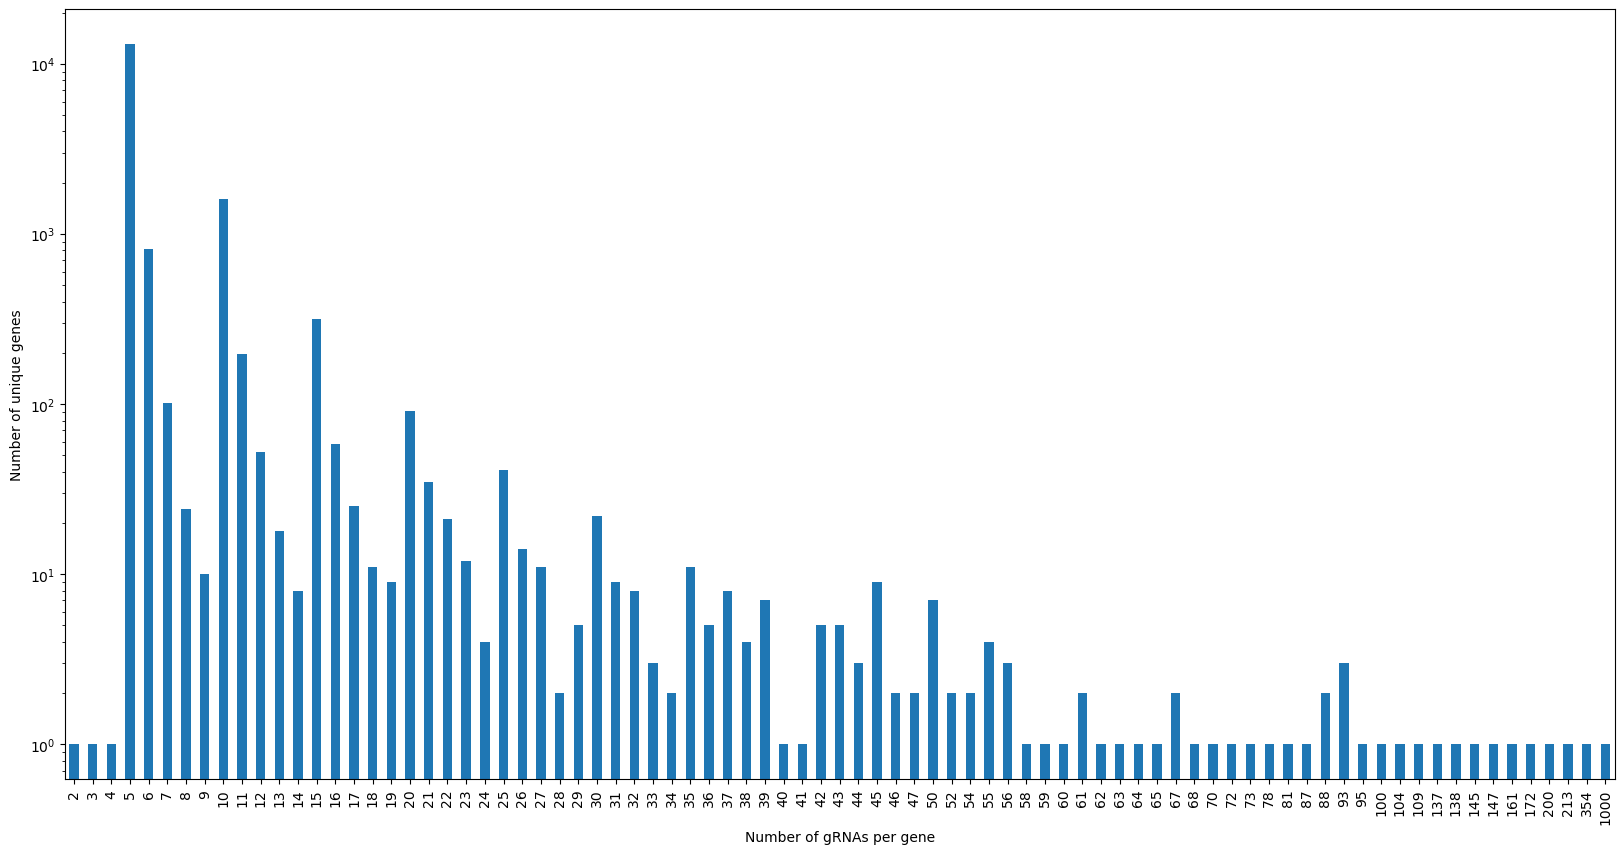

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 99.73%
grna with 0 reads: 207
skeq: 1.9821428571428572


In [11]:
b=lib_analysis_func("CHOK1-Cell-Lib_1.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
45000000
48000000
51000000
54000000
57000000
60000000
63000000
66000000
69000000
72000000
75000000
78000000
81000000
84000000
87000000
90000000
93000000
96000000
99000000
102000000
105000000
108000000
111000000
114000000
117000000
120000000
123000000
126000000
129000000
132000000
135000000
138000000
141000000
144000000
147000000
150000000
153000000
156000000
159000000
162000000
165000000
168000000
171000000
174000000
177000000
180000000
183000000
186000000
189000000
192000000
195000000
done
no left fragment found: 8.2%
no right fragment found: 1.6%
no left nor right found: 0.001%
percentage of reads with left and right: 90.7%
percent of good reads with target gRNA that is 20bp long: 98.6%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


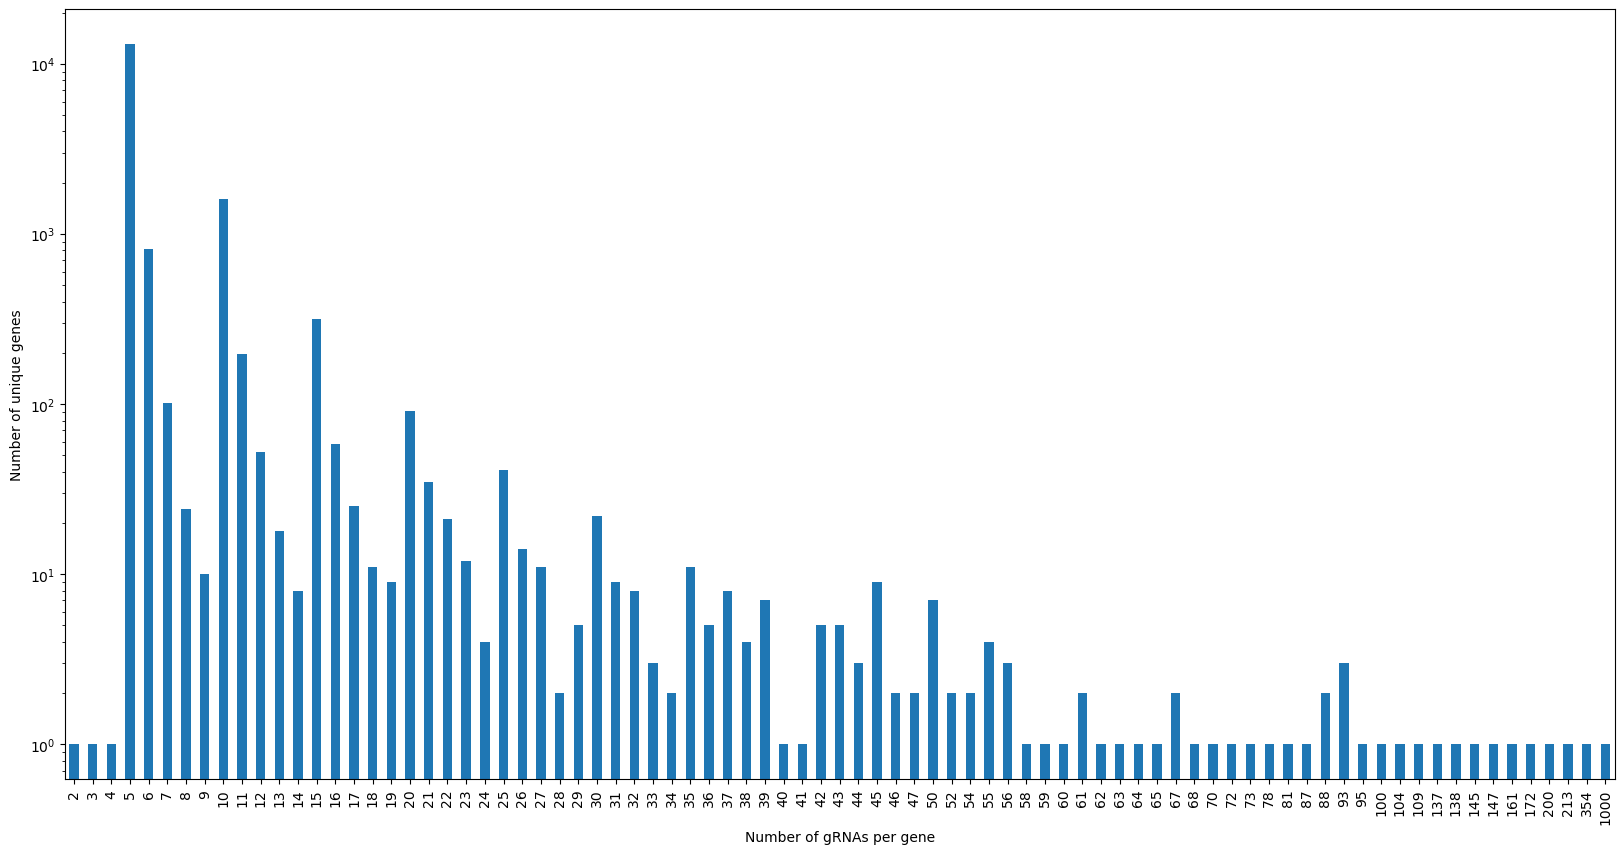

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 99.54%
grna with 0 reads: 384
skeq: 6.247311827956989


In [12]:
c=lib_analysis_func("screeon-Day0_S1_R1_001.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
45000000
48000000
51000000
54000000
57000000
60000000
63000000
66000000
69000000
72000000
75000000
78000000
81000000
84000000
87000000
90000000
93000000
96000000
99000000
102000000
105000000
108000000
111000000
114000000
117000000
120000000
123000000
126000000
129000000
132000000
135000000
138000000
141000000
144000000
147000000
150000000
153000000
156000000
159000000
162000000
165000000
168000000
done
no left fragment found: 8.4%
no right fragment found: 1.5%
no left nor right found: 0.001%
percentage of reads with left and right: 90.4%
percent of good reads with target gRNA that is 20bp long: 98.8%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


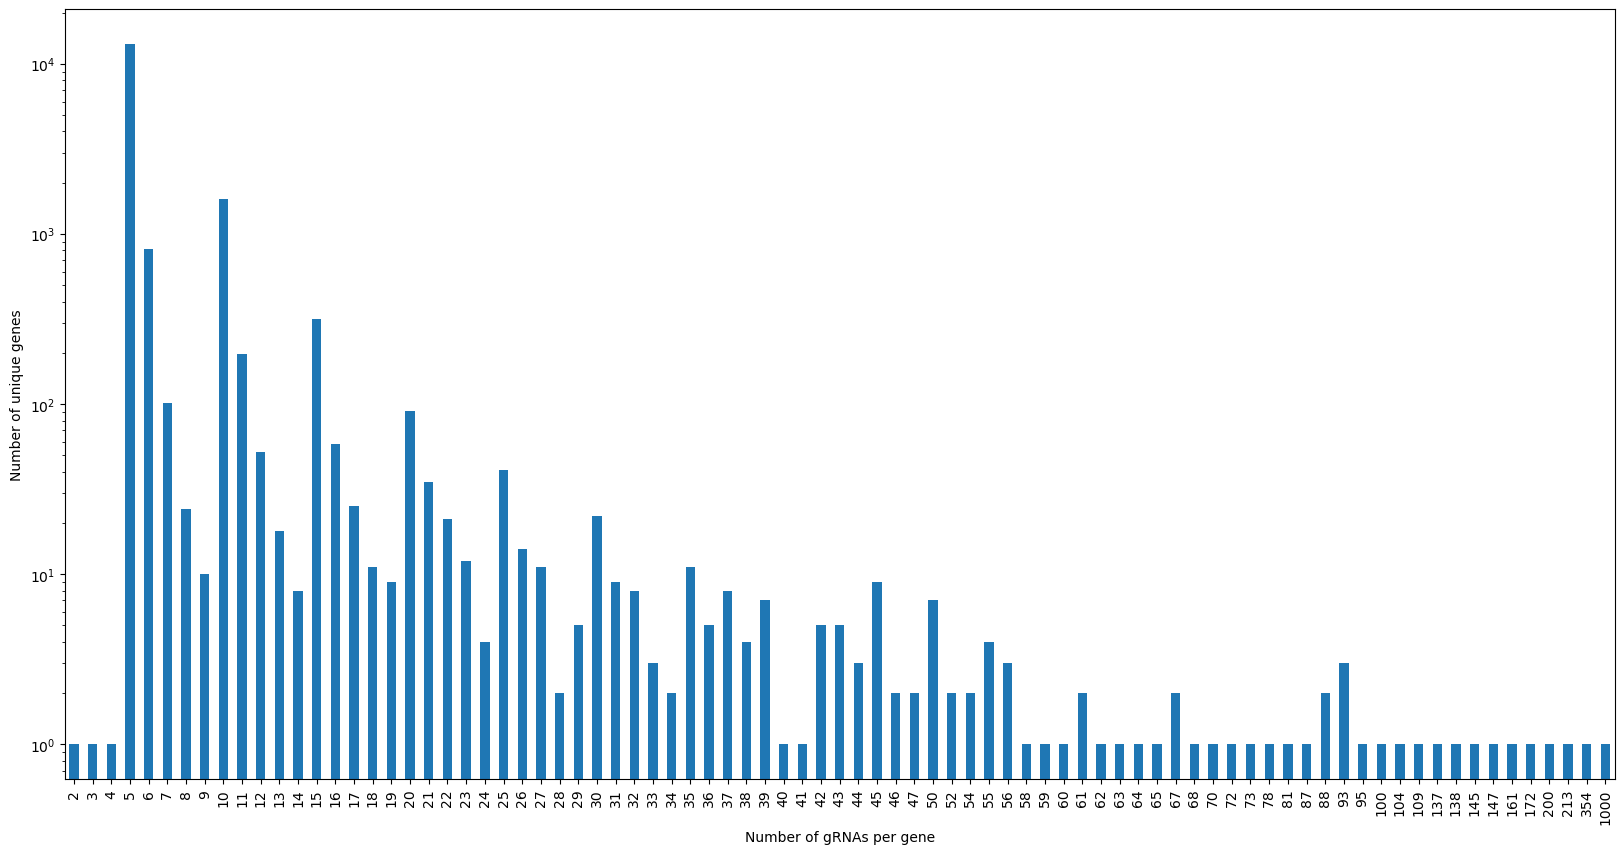

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 96.46%
grna with 0 reads: 3436
skeq: 36.588235294117645


In [25]:
d=lib_analysis_func("control-1_S2_R1_001.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
45000000
48000000
51000000
54000000
57000000
60000000
63000000
66000000
69000000
72000000
75000000
78000000
81000000
84000000
87000000
90000000
93000000
96000000
99000000
102000000
105000000
108000000
111000000
114000000
117000000
120000000
123000000
126000000
129000000
132000000
135000000
138000000
141000000
144000000
147000000
150000000
153000000
156000000
159000000
162000000
165000000
168000000
171000000
174000000
177000000
180000000
183000000
186000000
189000000
192000000
195000000
done
no left fragment found: 9.0%
no right fragment found: 1.5%
no left nor right found: 0.002%
percentage of reads with left and right: 89.9%
percent of good reads with target gRNA that is 20bp long: 98.8%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


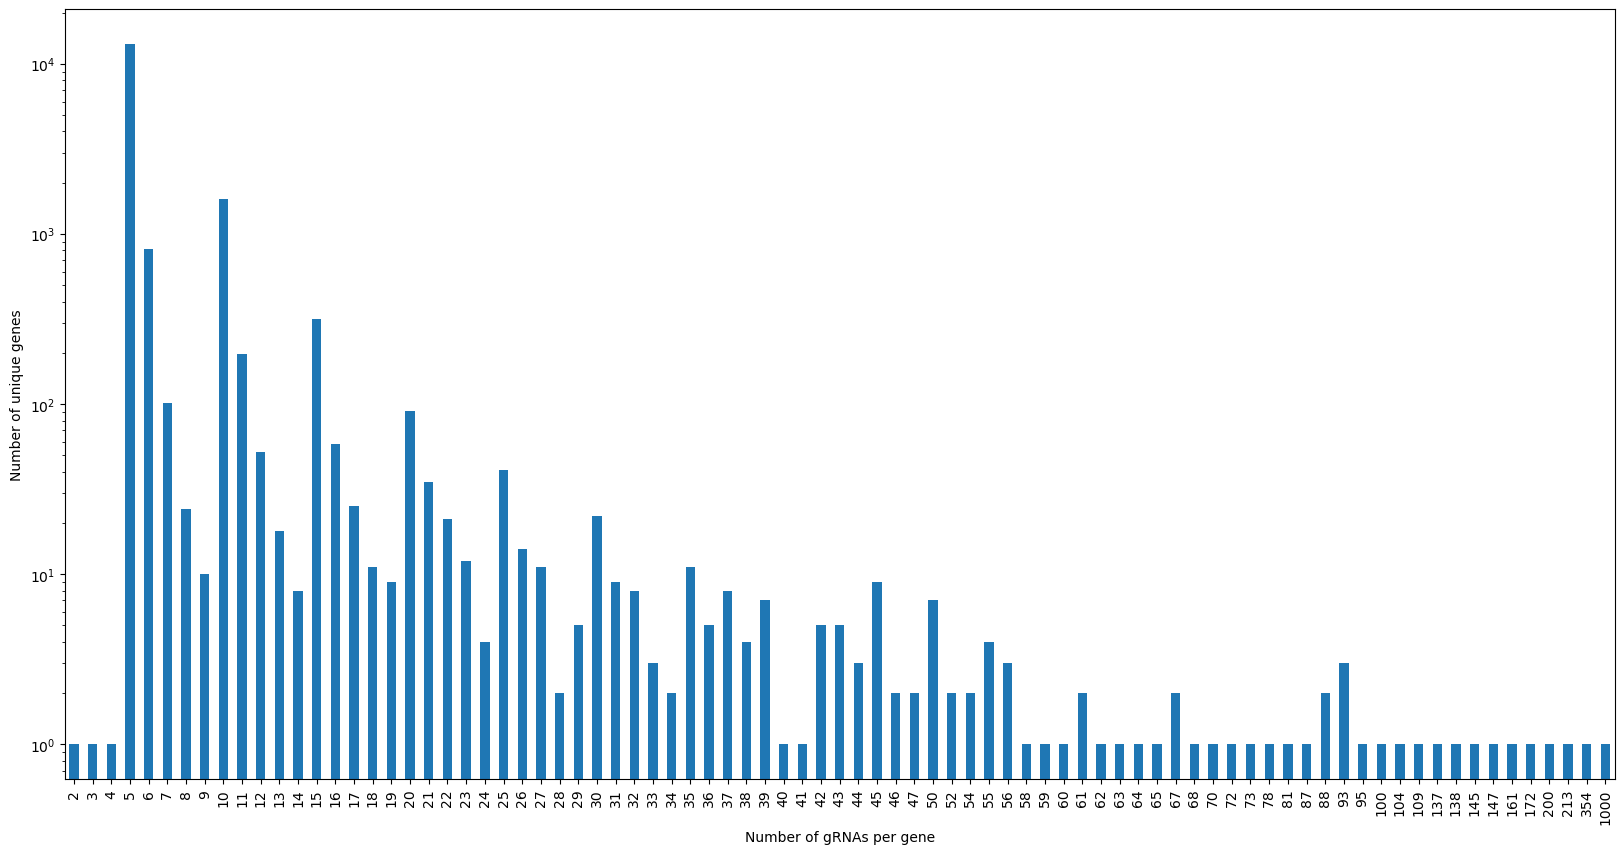

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 99.93%
grna with 0 reads: 65
skeq: 1.7813765182186234


In [41]:
e=lib_analysis_func("EPOfc_1.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
45000000
48000000
51000000
54000000
57000000
60000000
63000000
66000000
69000000
72000000
75000000
78000000
81000000
84000000
87000000
90000000
93000000
96000000
99000000
102000000
105000000
108000000
111000000
114000000
117000000
120000000
123000000
126000000
129000000
132000000
135000000
138000000
141000000
144000000
147000000
150000000
153000000
156000000
159000000
162000000
165000000
168000000
171000000
174000000
177000000
180000000
183000000
186000000
189000000
192000000
195000000
198000000
201000000
204000000
207000000
210000000
213000000
216000000
219000000
222000000
225000000
228000000
231000000
done
no left fragment found: 9.2%
no right fragment found: 1.6%
no left nor right found: 0.001%
percentage of reads with left and right: 89.6%
percent of good reads with target gRNA that is 20bp long: 98.5%

Design file analysis
see if we have duplic

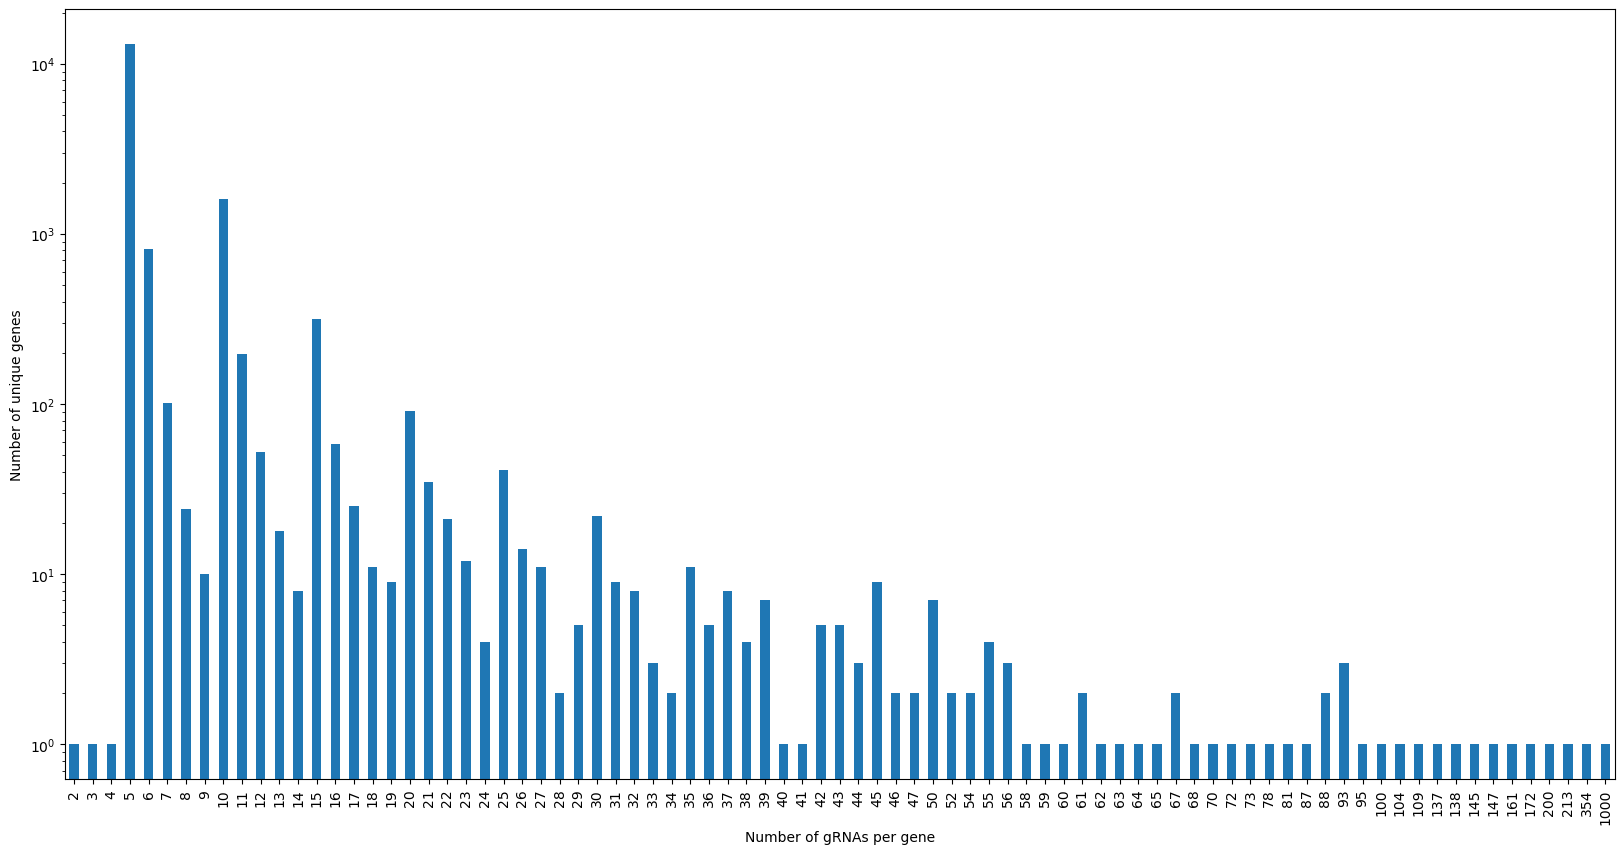

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 99.79%
grna with 0 reads: 185
skeq: 6.54054054054054


In [42]:
f=lib_analysis_func("EPOfc-KO_1.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

reading fastq
0
3000000
6000000
9000000
12000000
15000000
18000000
21000000
24000000
27000000
30000000
33000000
36000000
39000000
42000000
45000000
48000000
51000000
54000000
57000000
60000000
63000000
66000000
69000000
72000000
75000000
78000000
81000000
84000000
87000000
90000000
93000000
96000000
99000000
102000000
105000000
108000000
111000000
114000000
117000000
120000000
123000000
126000000
129000000
132000000
135000000
138000000
141000000
144000000
147000000
150000000
153000000
156000000
159000000
162000000
165000000
done
no left fragment found: 9.5%
no right fragment found: 1.9%
no left nor right found: 0.001%
percentage of reads with left and right: 89.0%
percent of good reads with target gRNA that is 20bp long: 98.6%

Design file analysis
see if we have duplicates
count
1    111651
Name: count, dtype: int64


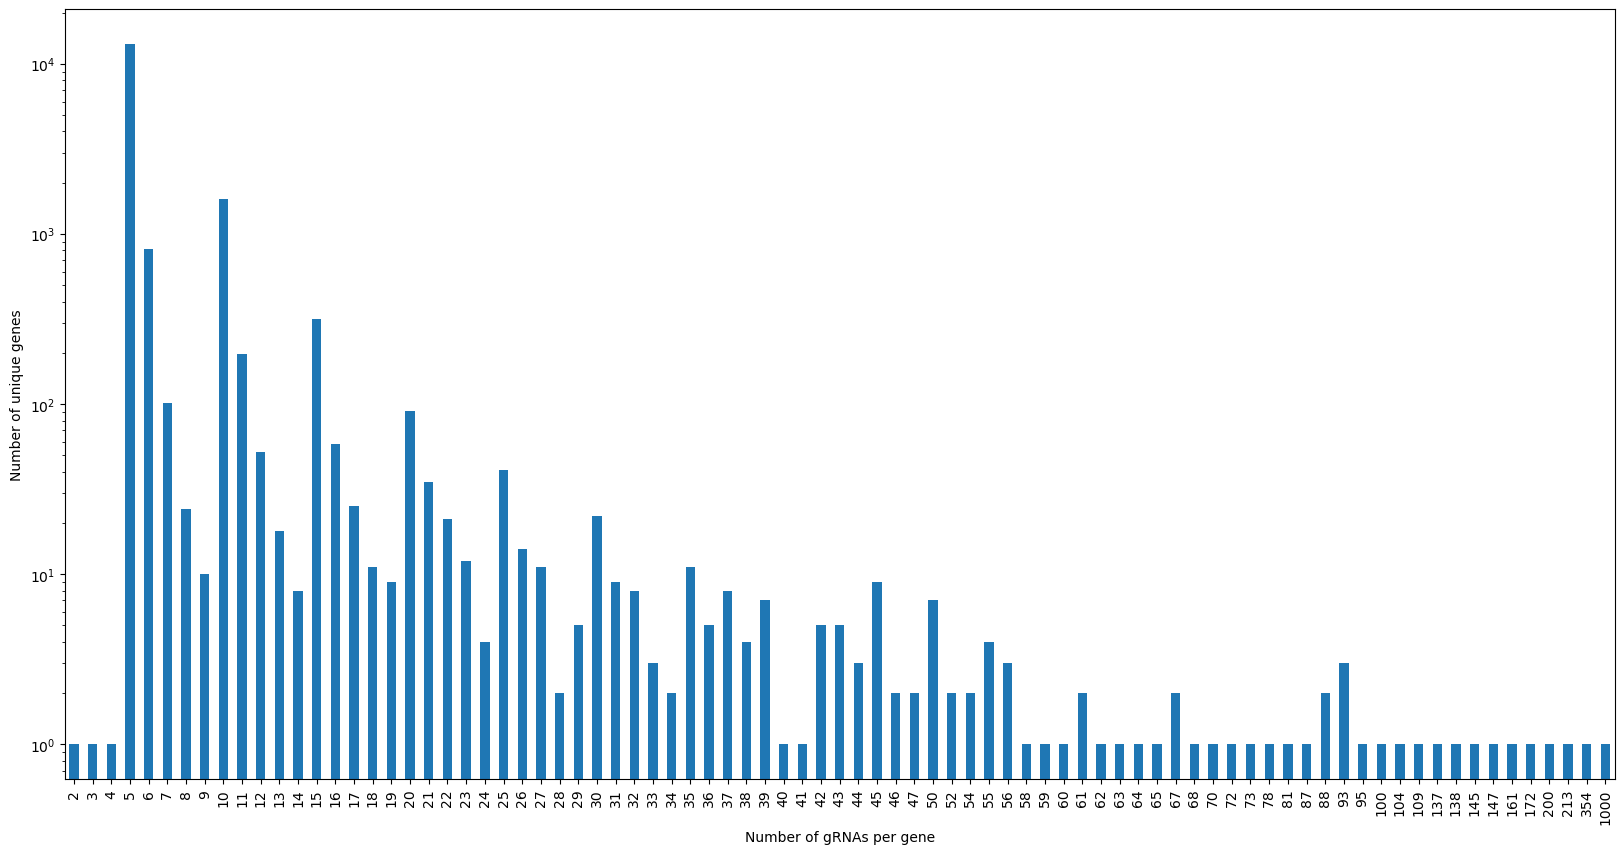

Number of unique genes (-1 non targeting control): 16696
Number of genes with more than 5 gRNA: 3657
Number of genes with less than 5 gRNA: 3
Percentage with 5 gRNA: 78.1%

merging fastq reads with design file
coverage (at least 1 count): 94.14%
grna with 0 reads: 5666
skeq: 97.83333333333333


In [43]:
g=lib_analysis_func("EPOfc_P7_1.fastq.gz", "20190901_Final_CRISPRKO_Library_CHOK1_CHOS_corrected.csv")

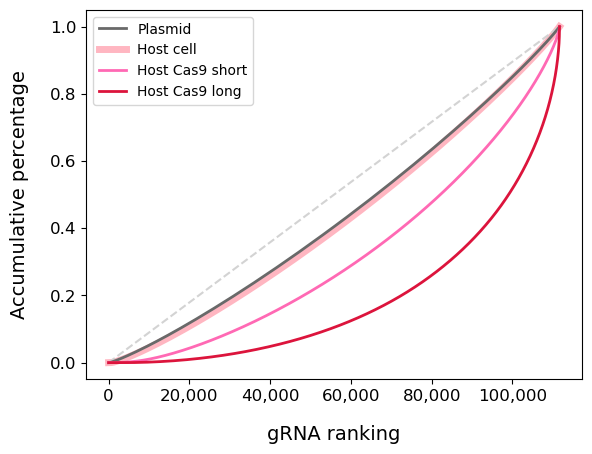

In [87]:
import matplotlib.ticker as ticker

ax = (b['target_count']/b['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='lightpink', label="Host cell", linewidth=5)
ax.plot((0,len(a)), (0,1), c='lightgray', ls='--')
(a['target_count']/a['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='dimgrey', label="Plasmid", linewidth=2)
(c['target_count']/c['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='hotpink', label="Host Cas9 short", linewidth=2)
(d['target_count']/d['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='crimson', label="Host Cas9 long", linewidth=2)
ax.set_xlabel("gRNA ranking", fontsize=14, labelpad=15)
ax.set_ylabel("Accumulative percentage", fontsize=14, labelpad=15)

plt.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax.get_legend_handles_labels()

new_order = [1, 0, 2, 3] 
new_handles = [handles[i] for i in new_order]
new_labels = [labels[i] for i in new_order]

formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)

ax.legend(new_handles, new_labels, loc='upper left')

plt.savefig("Fig. 4b legend final.png", facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

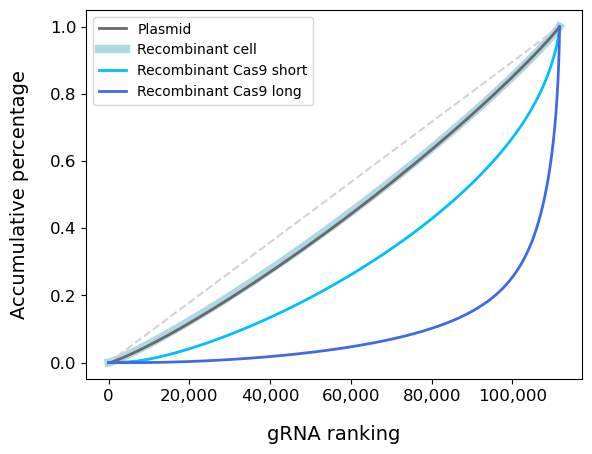

In [88]:
import matplotlib.ticker as ticker

ax = (e['target_count']/e['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='lightblue', label="Recombinant cell", linewidth=6)
ax.plot((0,len(a)), (0,1), c='lightgray', ls='--')
(a['target_count']/a['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='dimgrey', label="Plasmid", linewidth=2)
(f['target_count']/f['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='deepskyblue', label="Recombinant Cas9 short", linewidth=2)
(g['target_count']/g['target_count'].sum()).sort_values().cumsum().reset_index(drop=True).plot(c='royalblue', label="Recombinant Cas9 long", linewidth=2)
ax.set_xlabel("gRNA ranking", fontsize=14, labelpad=15)
ax.set_ylabel("Accumulative percentage", fontsize=14, labelpad=15)

ax.tick_params(axis='both', which='major', labelsize=12)

handles, labels = ax.get_legend_handles_labels()

new_order = [1, 0, 2, 3]
new_handles = [handles[i] for i in new_order]
new_labels = [labels[i] for i in new_order]

formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)

ax.legend(new_handles, new_labels, loc='upper left')

plt.savefig("Fig. 4c legend final.png", facecolor='white', dpi=300, bbox_inches='tight')
plt.show()

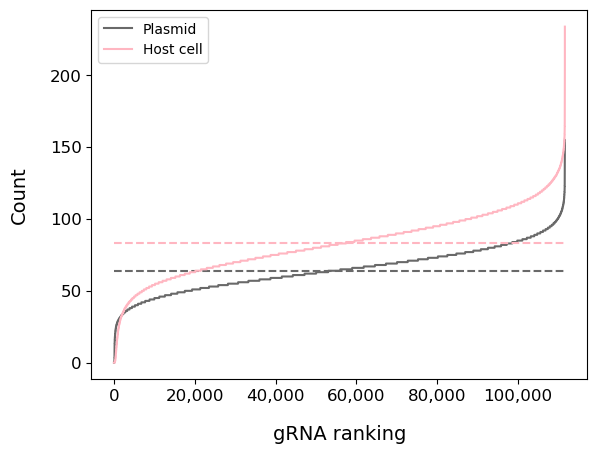

In [95]:
import matplotlib.ticker as ticker

ax = (a['target_count']).sort_values().reset_index(drop=True).plot(c='dimgrey', label="Plasmid")
ax.hlines(a['target_count'].median(), 0, len(a), colors='dimgrey', linestyles="--") 
(b['target_count']).sort_values().reset_index(drop=True).plot(c='lightpink', label="Host cell")
ax.hlines(b['target_count'].median(), 0, len(b), colors='lightpink', linestyles="--")
ax.set_xlabel("gRNA ranking", fontsize=14, labelpad=15)
ax.set_ylabel("Count", fontsize=14, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12)

formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(loc="upper left")
plt.savefig("Fig 4 host final", facecolor='white', bbox_inches='tight')
plt.show()

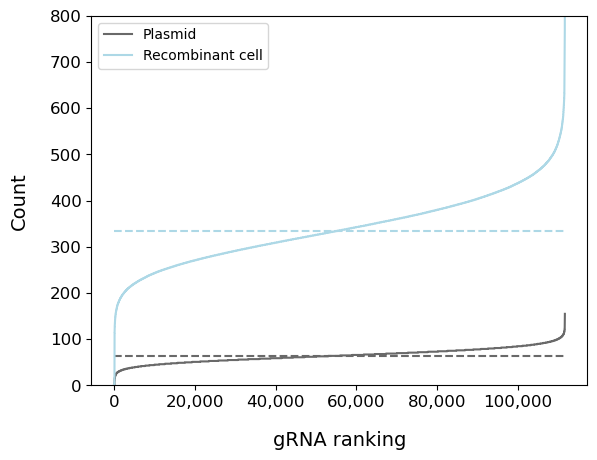

In [90]:
import matplotlib.ticker as ticker

ax = (a['target_count']).sort_values().reset_index(drop=True).plot(c='dimgrey', label="Plasmid")
ax.hlines(a['target_count'].median(), 0, len(a), colors='dimgrey', linestyles="--") 
(e['target_count']).sort_values().reset_index(drop=True).plot(c='lightblue', label="Recombinant cell")
ax.hlines(e['target_count'].median(), 0, len(e), colors='lightblue', linestyles="--")
ax.set_xlabel("gRNA ranking", fontsize=14, labelpad=15)
ax.set_ylabel("Count", fontsize=14, labelpad=15)
ax.tick_params(axis='both', which='major', labelsize=12)

formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
plt.gca().xaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylim(0, 800) 
plt.legend(loc="upper left")
plt.savefig("Fig 4 recombinant final", facecolor='white', bbox_inches='tight')
plt.show()